#Op Return

<a href="https://colab.research.google.com/github/ProfDoeg/Colegio_Invisible/blob/master/11_cuaderno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparar el Espacio (Prepare the Space)

In [1]:
! pip install eciespy eth_keys cryptos qrcode base58 
! git clone https://github.com/ProfDoeg/Colegio_Invisible.git

     |████████████████████████████████| 69 kB 5.3 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 555 kB 66.9 MB/s 
     |████████████████████████████████| 2.0 MB 45.7 MB/s 
     |████████████████████████████████| 105 kB 75.0 MB/s 
     |████████████████████████████████| 481 kB 71.6 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1230871 sha256=f2af545effe9a3fd5c73471aa5937f40ba7ba52f49fc4803280645bb2ab807f4
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
  Created wheel for qrcode: filename=qrcode-7.3.1-py3-none-any.whl size=40402 sha256=502cc01f0c7144b03f4662c606ce1a56c0b7b8751023efd7ec16e007a68be8c6
  Stored in directory: /root/.cache/pip/wheels/93/d7/39/a4111be2cfb8e679938aa671a37888b6afb1f9e7d748e94492
Successfully built cytoolz qrcode
Cloning into 'Colegio_Invisible'...
remote: Enumerating objects: 968, done.
remote: Counting

# Crear Transacciones de Criptomoneda (Create Cryptocurrency Transactions)

## Esquema (Outline) 

***

 
## Metas (Goals)
***
***
By the end of this notebook you should be able to:
***
Al final de este cuaderno, usted debería ser capaz de:
***
***
- Multisig
-

# Importaciones y Definiciones (Imports and Definitions)

Crear funciones para importar claves y direcciones de criptomonedas.
***
Create functions for importing keys and cryptocurrency addresses.

In [2]:
import pandas as pd
from cryptos.py3specials import safe_hexlify, from_string_to_bytes, from_int_to_byte, from_string_to_bytes
from cryptos import serialize,deserialize

import hashlib
import os
import getpass
import ecies
import eth_keys
import cryptos
import qrcode
import base58
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def import_privKey(privkey_filepath,password=None):
    if password==None:
        password = getpass.getpass("Input password for decrypting keyfile: ")
    password=password.encode()
    f=open(privkey_filepath,'rb')
    decrypted_bytes=ecies.aes_decrypt(key=hashlib.sha256(password).digest(),cipher_text=f.read())
    privKey=eth_keys.keys.PrivateKey(decrypted_bytes)
    return privKey

def import_pubKey(pubkey_filepath):
    f=open(pubkey_filepath,'rb')
    privKey=eth_keys.keys.PublicKey(f.read())
    return privKey

def import_addr(addr_filepath):
    return open(addr_filepath,'rb').read().decode()

def only_conf(utxos):
    return [utxo for utxo in utxos
            if doge.fetchtx(utxo['output'].split(':')[0])['confirmations']>0]

def mk_opreturn(msg, rawtx=None, json=0):
    
    def op_push(data):
        if type(data) == bytes:
            bytedata=data
        else:
            bytedata=data.encode()
        import struct
        if len(data) < 0x4c:
            return from_int_to_byte(len(bytedata)) + bytedata
        elif len(data) < 0xff:
            return from_int_to_byte(76) + struct.pack('<B', len(bytedata)) + bytedata
        elif len(data) < 0xffff:
            return from_int_to_byte(77) + struct.pack('<H', len(bytedata)) + bytedata
        elif len(data) < 0xffffffff:
            return from_int_to_byte(78) + struct.pack('<I', len(bytedata)) + bytedata
        else: raise Exception("Input data error. Rawtx must be hex chars" \
                            + "0xffffffff > len(data) > 0")

    orhex = safe_hexlify(b'\x6a' + op_push(msg))
    orjson = {'script' : orhex, 'value' : 0}
    if rawtx is not None:
        try:
            txo = deserialize(rawtx)
            if not 'outs' in txo.keys(): raise Exception("OP_Return cannot be the sole output!")
            txo['outs'].append(orjson)
            newrawtx = serialize(txo)
            return newrawtx
        except Exception as E:
            print(E)
            print(type(E))
            raise Exception("Raw Tx Error!")
    return orhex if not json else orjson

# Comenzar con Claves Existentes (Start with Existing Keys)

Acceder a las claves generadas en el cuaderno 5
***
Access the keys generated in the cuaderno 5

## Comenzar con Claves en Google Drive (Start with Keys on Google Drive)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
! cp drive/MyDrive/cinv/llaves.zip llaves.zip 
! unzip llaves.zip


Archive:  llaves.zip
   creating: llaves/
 extracting: llaves/mi_addr.bin      
 extracting: llaves/mi_addr.png      
 extracting: llaves/mi_pub.bin       
 extracting: llaves/mi_prv.enc       


## Comenzar con Claves en la Disco Local
## (Start with Keys on Local Drive)

In [ ]:
#from google.colab import files
#fu=files.upload();

In [ ]:
#! unzip llaves.zip

In [ ]:
#! ls llaves

# Import Private Key, Public Key and Address

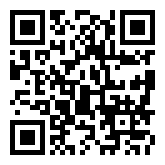

'0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5'

'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX'

In [6]:
from IPython.display import Image
qr=Image('llaves/mi_addr.png')

privKey=import_privKey('llaves/mi_prv.enc','')
pub=import_pubKey('llaves/mi_pub.bin').to_hex()
addr=import_addr('llaves/mi_addr.bin')

display(qr)
display(pub)
display(addr)

In [4]:
message='''Radio, live transmission.
Radio, live transmission.

Listen to the silence, let it ring on.
Eyes, dark grey lenses frightened of the sun.
We would have a fine time living in the night,
Left to blind destruction,
Waiting for our sight.

And we would go on as though nothing was wrong.
And hide from these days we remained all alone.
Staying in the same place, just staying out the time.
Touching from a distance,
Further all the time.

Dance, dance, dance, dance, dance, to the radio.
Dance, dance, dance, dance, dance, to the radio...

Well I could call out when the going gets tough.
The things that we've learnt are no longer enough.
No language, just sound, that's all we need know,
To synchronise love to the beat of the show.

And we could dance.

Dance, dance, dance, dance, dance, to the radio.
Dance, dance, dance, dance, dance, to the radio...
'''.encode()

In [9]:
type(message)

bytes

In [10]:
len(message)

853

In [12]:
list(range(0, len(message), 76))

[0, 76, 152, 228, 304, 380, 456, 532, 608, 684, 760, 836]

In [13]:
#message='hello to the world. this is a message to everyone who likes gravy. slow down. it is not healthy. it is too thick and sloppy'.encode()
n = 76 
chunks = [message[i:i+n] for i in range(0, len(message), n)]
chunks

[b'Radio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'let it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'a fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'sight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'days we remained all alone.\nStaying in the same place, just staying out the ',
 b'time.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'dance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"earnt are no longer enough.\nNo language, just sound, that's all we need know",
 b',\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, ',
 b'dance, dance, dance, dance, to the radio.\nDance, dance, dance, dance, dance,',
 b' to the radio...\n']

In [18]:
def pieces(bites,size):
    return [bites[i:i+n] for i in range(0, len(bites), n)]

In [14]:
def prepend_index(L):
    return [ int(i).to_bytes(1, 'big')+int(len(chunks)-1).to_bytes(1, 'big')+chunk for i,chunk in enumerate(L)]

In [15]:
def prepend_head(L,byte_head):
    return [ byte_head+chunk for chunk in L]

# byte head contains leading byte "\xdd" and byte to represent embed type
# a single line text will be embed type "\x00"
# a single line hash will be embed type "\x01"
# a multiline text will be embed type "\x02"
# a multiline ecies encrypted text will be embed type "\x03"

In [16]:
def multiline_setup(mensaje):
    mensaje_partes=pieces(mensaje,76)
    indexed_mensaje_partes=prepend_index(mensaje_partes)
    return prepend_head(indexed_mensaje_partes,b'\xdd\x02')

In [19]:
chunks=pieces(message,76)
chunks

[b'Radio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'let it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'a fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'sight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'days we remained all alone.\nStaying in the same place, just staying out the ',
 b'time.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'dance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"earnt are no longer enough.\nNo language, just sound, that's all we need know",
 b',\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, ',
 b'dance, dance, dance, dance, to the radio.\nDance, dance, dance, dance, dance,',
 b' to the radio...\n']

In [20]:
indexed_chunks=prepend_index(chunks)
indexed_chunks

[b'\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know",
 b'\t\x0b,\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, ',
 b'\n\x0bdance, dance, dance, dance, to the radio.\nDance, dance, dance, danc

In [24]:
headed_chunks=prepend_head(indexed_chunks,b'\xdd\x02')
headed_chunks

[b'\xdd\x02\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\xdd\x02\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\xdd\x02\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\xdd\x02\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\xdd\x02\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\xdd\x02\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\xdd\x02\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know",
 b'\xdd\x02\t\x0b,\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, 

In [21]:
opreturn_list=multiline_setup(message)
opreturn_list

[b'\xdd\x02\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\xdd\x02\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\xdd\x02\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\xdd\x02\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\xdd\x02\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\xdd\x02\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\xdd\x02\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know",
 b'\xdd\x02\t\x0b,\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, 

In [31]:
def embed_message_list(L,privkeyhex,tip=2_00_000_000):
    import time
    txn_ids=[]
    doge=cryptos.Doge()
    addy=doge.privtoaddr(privkeyhex)
    doge_unspents=only_conf( doge.unspent(addy) )
    doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents])
    if ( tip*len(L) + 3_00_000_000 ) > doge_unspent_total:
        raise Exception("Not enough coins available")
    # at this point we know we have enough coins...
    # now we will iterate through the list
    for op_return in L:
        print(op_return)
    # make sure to wait for utxos to confirm, if not wait 10 sec
        while True:
            doge_unspents=only_conf( doge.unspent(addy) )
            if doge_unspents != []:
              print('COINS UP')
              break
            time.sleep(20)
        doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents]) 
        doge_gift=doge_unspent_total-tip
        doge_outputs=[ {'value':doge_gift , 'address': addy}]
        doge_tx=doge.mktx(doge_unspents,doge_outputs)
        doge_serial_tx=cryptos.serialize(doge_tx)
        doge_inscribed_serial_tx=mk_opreturn( op_return , doge_serial_tx)
        doge_inscribed_tx=cryptos.deserialize(doge_inscribed_serial_tx)
        doge_signed_inscribed_tx=doge.signall(doge_inscribed_tx,privkeyhex)
        broadcast_doge_signed_inscribed_tx=doge.pushtx(doge_signed_inscribed_tx)
        txn_ids.append(broadcast_doge_signed_inscribed_tx['data']['txid'])
    return txn_ids

In [35]:
embed_message_list(opreturn_list[7:],privKey.to_hex()[2:],tip=2_00_000_000)

b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l"
COINS UP
b"\xdd\x02\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know"
COINS UP
b'\xdd\x02\t\x0b,\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, '
COINS UP
b'\xdd\x02\n\x0bdance, dance, dance, dance, to the radio.\nDance, dance, dance, dance, dance,'
COINS UP
b'\xdd\x02\x0b\x0b to the radio...\n'
COINS UP


['a76fbc9a793ecacabf28ee12ecb1716dbabe315e3b6fd58f0d3dc04b73bac1ae',
 '471720c333030d8c16c1ca35ddfab6705a2ca8d39d09dde37f486616b63972ba',
 '466ee54dbb8df470c075fd397274fee5f0c66e318c2be2cfa229fc88671cdec3',
 'b8ec2f72fd103ba895ca0c61a2bc6af84129fc5d924f6cd435be572b4183ed5c',
 '91d9f1573bacfac0e781764e5598318e1f9c00d22002db680e827469f268c7a8']

In [5]:
doge=cryptos.Doge()

In [6]:
H=doge.history('D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX')


In [36]:
lyric_txs=[ tx['txid'] for tx in H['data']['txs'][:13]][::-1]
#print(lyric_txs.pop(7))
lyric_txs

['49c862b789f6d4b9d681e5c4cb8523157f730cb7f108a71ae2a9bbb77c7d95f4',
 '4a3c2a16db96681b4351b3bb642d12e69a27f1f695323ef5dd1b4c5628cd8127',
 '58f58c2d1694653a8396f0feae41f00a1852fe4a6b6ba782d72e22f93720a9ba',
 'f30809fbe7ccba952712695bf827f9595744d4c8ae9fb5f6a8d7d21b39960024',
 '48192af05a3aaf8cf8b3eaae01aa280573cf2f4e402a94e3fdda0748a45fd341',
 '0bb797690b76e7c678d06565220ba7dcdbafed92373ea22fe49494a7e0f55fe5',
 'c24330aaa69b0b6ec7ec04824a4eed28982d6c6d049adc986705945fc96db6d5',
 'b0821e8b53e2985c59f06d32318ae89743943e3d901ca7d95b6dd1d453f0d56b',
 'a76fbc9a793ecacabf28ee12ecb1716dbabe315e3b6fd58f0d3dc04b73bac1ae',
 '471720c333030d8c16c1ca35ddfab6705a2ca8d39d09dde37f486616b63972ba',
 '466ee54dbb8df470c075fd397274fee5f0c66e318c2be2cfa229fc88671cdec3',
 'b8ec2f72fd103ba895ca0c61a2bc6af84129fc5d924f6cd435be572b4183ed5c',
 '91d9f1573bacfac0e781764e5598318e1f9c00d22002db680e827469f268c7a8']

In [37]:
[ output['script'] for output in doge.fetchtx(lyric_txs[0])['outputs'] if 'OP_RETURN' in output['script']][0][10:]

'dd02000b526164696f2c206c697665207472616e736d697373696f6e2e0a526164696f2c206c697665207472616e736d697373696f6e2e0a0a4c697374656e20746f207468652073696c656e63652c20'

In [38]:
def tx2opreturn(txn):
    doge=cryptos.Doge()
    return [ output['script'] for output in doge.fetchtx(txn)['outputs'] if 'OP_RETURN' in output['script']][0][10:]

In [42]:
opreturns=[bytes.fromhex(tx2opreturn(txn)) for txn in lyric_txs]
opreturns

[b'\xdd\x02\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\xdd\x02\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\xdd\x02\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\xdd\x02\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\xdd\x02\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\xdd\x02\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\xdd\x02\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know

In [59]:
import pandas as pd
opreturns_series=pd.Series(opreturns)
opreturns_series.drop_duplicates(inplace=True)
opreturns=opreturns_series.to_list()
opreturns

[b'\xdd\x02\x00\x0bRadio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'\xdd\x02\x01\x0blet it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'\xdd\x02\x02\x0ba fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'\xdd\x02\x03\x0bsight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'\xdd\x02\x04\x0bdays we remained all alone.\nStaying in the same place, just staying out the ',
 b'\xdd\x02\x05\x0btime.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'\xdd\x02\x06\x0bdance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"\xdd\x02\x07\x0b..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"\xdd\x02\x08\x0bearnt are no longer enough.\nNo language, just sound, that's all we need know",
 b'\xdd\x02\t\x0b,\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, 

In [62]:
[ opreturn[4:] for opreturn in opreturns] 

[b'Radio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 b'let it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 b'a fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 b'sight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 b'days we remained all alone.\nStaying in the same place, just staying out the ',
 b'time.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 b'dance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 b"..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 b"earnt are no longer enough.\nNo language, just sound, that's all we need know",
 b',\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, ',
 b'dance, dance, dance, dance, to the radio.\nDance, dance, dance, dance, dance,',
 b' to the radio...\n']

In [30]:
[bytes.fromhex(tx2opreturn(txn)[8:]).decode() for txn in lyric_txs]

['Radio, live transmission.\nRadio, live transmission.\n\nListen to the silence, ',
 'let it ring on.\nEyes, dark grey lenses frightened of the sun.\nWe would have ',
 'a fine time living in the night,\nLeft to blind destruction,\nWaiting for our ',
 'sight.\n\nAnd we would go on as though nothing was wrong.\nAnd hide from these ',
 'days we remained all alone.\nStaying in the same place, just staying out the ',
 'time.\nTouching from a distance,\nFurther all the time.\n\nDance, dance, dance, ',
 'dance, dance, to the radio.\nDance, dance, dance, dance, dance, to the radio.',
 "..\n\nWell I could call out when the going gets tough.\nThe things that we've l",
 "earnt are no longer enough.\nNo language, just sound, that's all we need know",
 ',\nTo synchronise love to the beat of the show.\n\nAnd we could dance.\n\nDance, ',
 'dance, dance, dance, dance, to the radio.\nDance, dance, dance, dance, dance,',
 ' to the radio...\n']

In [31]:
print(''.join([bytes.fromhex(tx2opreturn(txn)[4:]).decode() for txn in lyric_txs]))

Radio, live transmission.
Radio, live transmission.

Listen to the silence, let it ring on.
Eyes, dark grey lenses frightened of the sun.
We would have a fine time living in the night,
Left to blind destruction,
Waiting for our sight.

And we would go on as though nothing was wrong.
And hide from these days we remained all alone.
Staying in the same place, just staying out the time.
Touching from a distance,
Further all the time.

Dance, dance, dance, dance, dance, to the radio.
Dance, dance, dance, dance, dance, to the radio...

Well I could call out when the going gets tough.
The things that we've learnt are no longer enough.
No language, just sound, that's all we need know,
To synchronise love to the beat of the show.

And we could dance.

Dance, dance, dance, dance, dance, to the radio.
Dance, dance, dance, dance, dance, to the radio...



In [65]:
def extract_multiline(txs):
    import pandas as pd
    byte_returns=[bytes.fromhex(tx2opreturn(txn)) for txn in txs]
    unique_byte_returns=sorted(pd.Series(byte_returns).drop_duplicates().to_list())
    return ''.join([elem[4:].decode() for elem in unique_byte_returns])

In [67]:
joy_div=extract_multiline(lyric_txs)
print(joy_div)

Radio, live transmission.
Radio, live transmission.

Listen to the silence, let it ring on.
Eyes, dark grey lenses frightened of the sun.
We would have a fine time living in the night,
Left to blind destruction,
Waiting for our sight.

And we would go on as though nothing was wrong.
And hide from these days we remained all alone.
Staying in the same place, just staying out the time.
Touching from a distance,
Further all the time.

Dance, dance, dance, dance, dance, to the radio.
Dance, dance, dance, dance, dance, to the radio...

Well I could call out when the going gets tough.
The things that we've learnt are no longer enough.
No language, just sound, that's all we need know,
To synchronise love to the beat of the show.

And we could dance.

Dance, dance, dance, dance, dance, to the radio.
Dance, dance, dance, dance, dance, to the radio...



In [143]:
#weird opreturn i found in dogecoin blockchain
bytes.fromhex('737761703a424e422e425553442d4244313a626e6231726e7667326b3537776e6d32747578336c386e34647672753671676465746e6b7739647368343a313738333134373632343939')

b'swap:BNB.BUSD-BD1:bnb1rnvg2k57wnm2tux3l8n4dvru6qgdetnkw9dsh4:178314762499'